In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from pygam import LogisticGAM

### Question 4

In [2]:
marketing_data = pd.read_csv("marketing.csv")

In [3]:
marketing_data_encoded = pd.get_dummies(columns=["job", "marital", "education","default", "housing","loan"],
                                        data=marketing_data)
marketing_data_encoded['y'] = np.where(marketing_data_encoded['y'] == 'yes',1,0)

In [4]:
X = marketing_data_encoded.drop(axis=1,columns=['y'])
y = marketing_data_encoded[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#### Part (a)

In [5]:
base_rate = sum(y_train.y==1)/len(y_train)
print("Base rate of success in the training data is", round(base_rate,3))

Base rate of success in the training data is 0.118


#### Part (b)

In [112]:
X_train.columns

Index(['age', 'balance', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes'],
      dtype='object')

In [6]:
lmfit = LogisticRegression(C=100000).fit(X_train, y_train)

yhat_lm = lmfit.predict(X_test)

C:\Users\shuva\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
miss_rate = np.mean(np.array(y_test)!=yhat_lm)
print("Misclassification rate of logistic regression is", round(miss_rate,6))


Misclassification rate of logistic regression is 0.115436


#### Part (c)

In [146]:
silly_classifier_miss_rate = sum(y_test.y==1)/len(y_test)
print("Misclassification rate of classifier which guesses no for all observation is ", round(silly_classifier_miss_rate,6))

Misclassification rate of classifier which guesses no for all observation is  0.115282


The misclassification rate of the logistic classifier is more than a silly classifier which guess no all the time. This shows that the logistic regression did poorly on the 0-1 loss as it is comparable to a no-model classifier in terms of 0-1 loss.

#### Part (d)

In [189]:
test_log_prob = lmfit.predict_log_proba(X_test)[:,1]
#Partitions the array into two sub-arrays like quick sort. Left of the index are all less than the index
#Picks 1000 highest log-probability points
high_prob_indices = np.argpartition(test_log_prob, len(test_log_prob)-1000)[-1000:]

In [198]:
success_count_frac = sum(y_test.iloc[high_prob_indices].y == 1)/1000
print("Among this set of 1000 clients, success fraction is", round(success_count_frac,3))
print("Random pick of 1000 clients from the set would have a success fraction of ", round(sum(y_test.y==1)/len(y_test),3))

Among this set of 1000 clients, success fraction is 0.279
Random pick of 1000 clients from the set would have a success fraction of  0.115


In [12]:
prob = lmfit.predict_proba(X_test)[:,1]
lmfit_score = pd.DataFrame(columns=["score"],data=prob)
lmfit_score.to_csv("lmfit.csv")

The set of 1000 clients with highest log probability of success has a success rate of 27.9% compared to 11.5% for a random set of 1000 clients. This shows the efficiency of the enriched set.

#### Part (e)

In [205]:
fpr,tpr,_ = roc_curve(y_test.y,lmfit.predict_proba(X_test)[:,1])

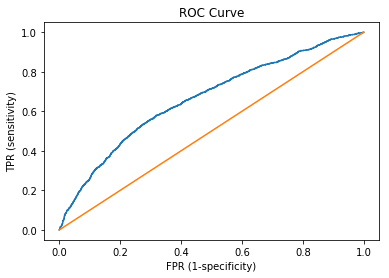

In [210]:
plt.plot(fpr,tpr)
plt.xlabel("FPR (1-specificity)")
plt.ylabel("TPR (sensitivity)")
plt.title("ROC Curve")
plt.plot(np.linspace(0,1), np.linspace(0,1))
plt.show()

We can see from above plot that the ROC curve is above the $y=x$ line thus the logistic classifier is better than random guessing for this data set.

### Question 5

#### Part (a)

In [217]:
GAMfit = LogisticGAM().gridsearch(np.array(X_train), np.array(y_train), lam = np.logspace(-2, 3, 30))

100% (30 of 30) |########################| Elapsed Time: 0:04:40 Time:  0:04:40


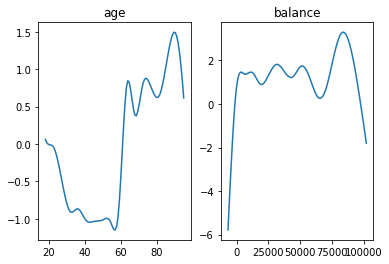

In [220]:
fig, axs = plt.subplots(1, 2)
titles = ['age', 'balance']

for i, ax in enumerate(axs):
    Xfake = GAMfit.generate_X_grid(i)
    pdep, confi = GAMfit.partial_dependence(term = i, X= Xfake, width=.95)

    ax.plot(Xfake[:, i], pdep)
    #ax.plot(XX[:, i], confi[0], c='r', ls='--')
    ax.set_title(titles[i])

plt.show()

Above shows the partial dependency plot for the continuous variables age, balance and we can observe significant non-linearities in between the response and the predictors that cannot be captured by the linear logistic regression.

#### Part (b)

In [223]:
yhat_gam = GAMfit.predict(np.array(X_test))
print("Misclassification rate for Logistic GAM fit is", round(np.mean(yhat_gam!=np.array(y_test)),3))

Misclassification rate for Logistic GAM fit is 0.121


In [231]:
gam_test_log_prob = GAMfit.predict_proba(np.array(X_test))
#Partitions the array into two sub-arrays like quick sort. Left of the index are all less than the index
#Picks 1000 highest log-probability points
high_prob_indices = np.argpartition(gam_test_log_prob, len(gam_test_log_prob)-1000)[-1000:]

In [233]:
success_count_frac = sum(y_test.iloc[high_prob_indices].y == 1)/1000
print("Among this set of 1000 clients, success fraction is", round(success_count_frac,3))
print("Random pick of 1000 clients from the set would have a success fraction of ", round(sum(y_test.y==1)/len(y_test),3))

Among this set of 1000 clients, success fraction is 0.346
Random pick of 1000 clients from the set would have a success fraction of  0.115


Although the logistic GAM classifier has higher misclassification rate than the logistic regression classifier, we can see that it provides better success fraction for the top 1000 clients with highest probability of success. Thus we expect the enriched set to have better ROC curve characteristics than the logistic regression curve.

#### Part (c)


In [234]:
fpr_gam,tpr_gam,_ = roc_curve(y_test.y,GAMfit.predict_proba(np.array(X_test)))

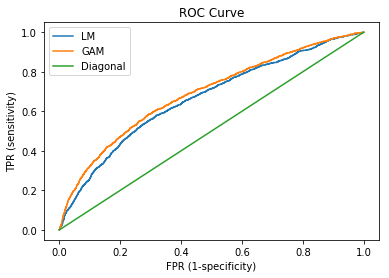

In [243]:
plt.plot(fpr,tpr)
plt.xlabel("FPR (1-specificity)")
plt.ylabel("TPR (sensitivity)")
plt.title("ROC Curve")
plt.plot(fpr_gam,tpr_gam)
plt.plot(np.linspace(0,1), np.linspace(0,1))
plt.gca().legend(('LM','GAM',"Diagonal"))
plt.show()

We can see from the above plot that the ROC curve of Logistic GAM based classifier is slightly above the ROC curve of Logistic regression based classifier, which is also supported by better success fraction among the top 1000 set shows that the logistic GAM is better able to capture the non-linearities induced by the age and balance continuous variables.